# Description

This notebook was used to process the corpora created in the data_extraction notebooks, find the optimal hyperparameters for LDA, train and fit the optimal LDA models and create timeline graphs. This notebook does this for the CAN dataset.

**Note**: some sections (tokenization and finding optimal hyperparameters) are commented out since the resulting datasets and models are serialized with pickle and can simply be loaded in. If you want to run the processing yourself, simply uncomment these. Be aware that the processing might take some time.

In [3]:
import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import random
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
from collections import Counter

DATA_PATH = "../data"
VIS_PATH = "../visualisations"
model = spacy.load("en_core_web_trf")

## Load data

In [4]:
data = pd.read_pickle(DATA_PATH + "/processed/dataset_CAN+date_tokenized.pkl")

len_desc = sum([len(x) for x in data["Short description"].str.split(" ") if x is not None])
len_desc_tok = sum([len(x) for x in data["Short description tokenized"].str.split(" ") if x is not None])
print(f"Number of tokens in short description corpus: {len_desc}")
print(f"Number of tokens in short description tokenized corpus: {len_desc_tok}")
data.head()

Number of tokens in short description corpus: 14989
Number of tokens in short description tokenized corpus: 9683


,Contract,Title,Type of contract,Short description,Total value,Place of performance,Contractor,Notice dispatch date,Short description tokenized
0,000007-2017,Framework contract for the provision of passen...,SERVICES,Provision of passenger transfer services by bu...,150000.0,GR,[Vagia Tzislaki — Lesvorama General Travel Age...,2016-12-22,provision passenger transfer service bus greec...
1,000007-2017,Framework contract for the provision of passen...,SERVICES,Provision of passenger services by bus in Gree...,150000.0,GR,[Vagia Tzislaki — Lesvorama General Travel Age...,2016-12-22,provision passenger service bus greece chios i...
2,000007-2017,Framework contract for the provision of passen...,SERVICES,Framework contract for the provision of passen...,NaN,GR,None,2016-12-22,framework contract provision passenger transfe...
3,008449-2018,Provision of HID® FARGO® HDP5000 ID card print...,SUPPLIES,The subject of the contract is provision of HI...,190000.0,PL,[Control system FMN Sp z oo],2018-01-04,subject contract provision hid ® fargo ® hdp50...
4,008450-2018,Provision of painting services for Frontex,SERVICES,Provision of painting services for Frontex.,NaN,PL,None,2018-01-04,provision painting service frontex


Text(0.5, 1.0, 'Number of CAN awards per year')

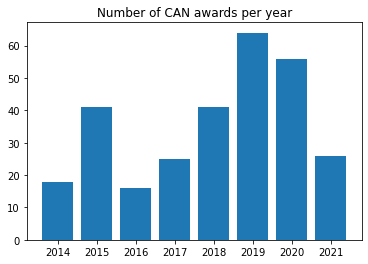

In [5]:
# plot the number of CAN awards per year
count_dict = Counter([int(x[0]) for x in data["Notice dispatch date"].str.split("-")])
plt.bar(count_dict.keys(), count_dict.values())
plt.title("Number of CAN awards per year")

## Tokenization

In [6]:
def tokenize(sample):
    """
    Tokenizes and filters a short description text.
    """
    
    if not sample:
        return None
    
    tokens = []
    doc = model(sample)
    for token in doc:
        if token.pos_ != "PUNCT":
            token_processed = token.lemma_.lower().strip()
        
            if token_processed not in STOP_WORDS:
                tokens.append(token_processed)        
    return " ".join(tokens)

In [8]:
# test tokenization
sample = data.sample()["Short description"].iloc[0]
print(sample)
print()
print(tokenize(sample))

This framework contract shall be considered as the source for contracting software development services mainly under quoted times and means and fixed price assignments. Software development services shall be understood in broad meaning with reference to all phases of software life cycle and technical domains of software engineering. Therefore, it may cover typical software development as well as maintenance of existing software, refactoring, tuning, etc.

framework contract shall consider source contract software development service mainly quote time mean fix price assignment software development service shall understand broad meaning reference phase software life cycle technical domain software engineering cover typical software development maintenance exist software refactoring tuning etc


In [5]:
# # add a new column to the dataset, namely the tokenized versions of the short description
# data["Short description tokenized"] = data["Short description"].apply(tokenize)
# data.to_pickle(DATA_PATH + "/processed/dataset_CAN+date_tokenized.pkl")

## Preprocess data

In [3]:
# filter datapoints with invalid or missing descriptions
descriptions = data[data["Short description tokenized"].notna()].reset_index(drop=True)
tokenized_descriptions = descriptions["Short description tokenized"]

# vectorize data, that is create matrix of word counts per document
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(tokenized_descriptions)

# total word counts
word_freq = [np.sum(data_vectorized.toarray()[:,index]) for index in range(len(vectorizer.get_feature_names()))]

## Find optimal hyperparameters

In [16]:
# # for each k in a range of [2-50] train a LDA model and save the log-likelihood,
# # perplexity and U_mass coherence score.
# log_likelihoods = []
# perplexities = []
# coherences = []
# ks = list(range(2, 50))
# for i in ks:
#     lda = LatentDirichletAllocation(n_components=i, learning_method='online')
#     data_lda = lda.fit_transform(data_vectorized)
    
#     coherence = metric_coherence_gensim(
#         measure='u_mass',
#         topic_word_distrib=lda.components_,
#         dtm=data_vectorized.toarray(),
#         vocab=np.array(vectorizer.get_feature_names())
#     )
#     coherences.append(np.mean(coherence))
    
#     log_likelihoods.append(lda.score(data_vectorized))
#     perplexities.append(lda.perplexity(data_vectorized))

3 highest log likelihoods: [-54970.37885831 -55643.18089363 -55758.90907504]
Associated k's: [12, 11, 9]


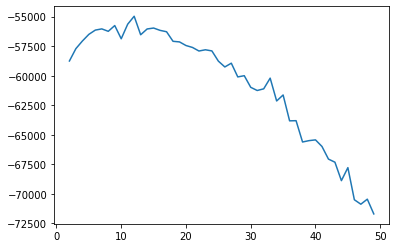

In [17]:
# plt.plot(ks, log_likelihoods)

# top_n = 3
# print(f"{top_n} highest log likelihoods: {np.sort(log_likelihoods)[::-1][:top_n]}")
# print(f"Associated k's: {[ks[i] for i in np.argsort(log_likelihoods)[::-1][:top_n]]}")

3 lowest perplexities: [365.5032751  392.87953893 397.79106302]
Associated k's: [12, 11, 9]


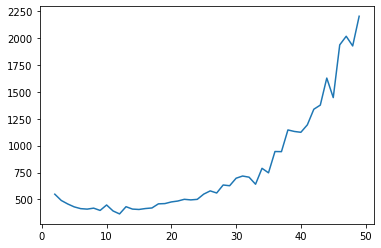

In [18]:
# plt.plot(ks, perplexities)

# top_n = 3
# print(f"{top_n} lowest perplexities: {np.sort(perplexities)[:top_n]}")
# print(f"Associated k's: {[ks[i] for i in np.argsort(perplexities)[:top_n]]}")

3 highest cv coherence: [-2.59054285 -3.85326053 -4.86677231]
Associated k's: [2, 4, 7]


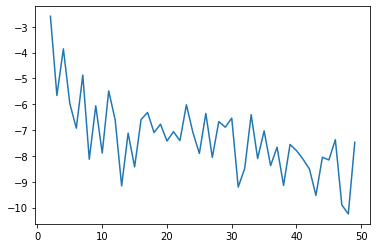

In [19]:
# plt.plot(ks, coherences)

# top_n = 3
# print(f"{top_n} highest cv coherence: {np.sort(coherences)[::-1][:top_n]}")
# print(f"Associated k's: {[ks[i] for i in np.argsort(coherences)[::-1][:top_n]]}")

## Optimal model

In [336]:
# LDA using optimal k
lda = LatentDirichletAllocation(n_components=9, learning_method='online')
lda.fit(data_vectorized)

# transform data
data_lda = lda.transform(data_vectorized)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

#### Save model

In [338]:
# import pickle
# MODELS_PATH = "../models"

# with open(MODELS_PATH + "/MODELNAME.pkl", "wb") as f:
#     pickle.dump(lda, f)

#### Load model

In [4]:
import pickle
MODELS_PATH = "../models"

with open(MODELS_PATH + "/scikitLDA_CAN_k9.pkl", "rb") as f:
    lda = pickle.load(f)
    
# transform data
data_lda = lda.transform(data_vectorized)

## Visualize topics

In [11]:
plot = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer, mds='tsne', sort_topics=False)

# uncomment to export the graph as html
# pyLDAvis.save_html(plot, VIS_PATH + '/PLOTNAME.html')

# show plot
plot

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      -61.876961   62.040791       1        1  12.874006
1       58.314384  -19.816950       2        1   2.206649
2       26.729540   77.765854       3        1   4.559401
3      -11.237781   -2.648332       4        1   5.692407
4      137.439011  -39.396515       5        1  16.683709
5      107.388351   50.596363       6        1  23.544937
6      -15.124341  -91.477036       7        1  25.779337
7       68.902931 -104.990898       8        1   5.450415
8      -86.195625  -36.257202       9        1   3.209140, topic_info=              Term        Freq       Total Category  logprob  loglift
1062      software  155.000000  155.000000  Default  30.0000  30.0000
1036       service  283.000000  283.000000  Default  29.0000  29.0000
1119  surveillance   92.000000   92.000000  Default  28.0000  28.0000
485        frontex  204.000000  204.000000  Default  27.0000  27.0000
336    development   75.000000   75.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
80       amendment    2.093429    4.596973   Topic9  -4.9614   2.6526
790       organise    2.189902    7.058719   Topic9  -4.9164   2.2688
671            lot    4.672721   60.538993   Topic9  -4.1585   0.8776
691       maritime    3.378453   34.540531   Topic9  -4.4828   1.1145
146         border    2.348538   56.987909   Topic9  -4.8464   0.2501

[462 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
1         5  0.150068   000
1         8  0.150068   000
1         9  0.600273   000
4         3  0.695701   100
4         5  0.298157   100
...     ...       ...   ...
1235      9  0.039408  work
1246      1  0.121091  year
1246      5  0.666000  year
1246      7  0.121091  year
1246      8  0.060545  year

[700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
# name topics
topic_names_k7 = {
    1 : 'deployment?',
    2 : 'clothing/uniforms',
    3 : 'presentations/markets',
    4 : 'information systems',
    5 : 'local frontex operations',
    6 : 'software development',
    7 : 'surveillance'
}

topic_names_k9 = {
    1 : 'information systems',
    2 : 'local operational support',
    3 : 'organised events',
    4 : 'border checkpoint',
    5 : 'contract',
    6 : 'software development',
    7 : 'surveillance',
    8 : 'ground support/equipment',
    9 : 'clothing/uniforms',
}

topic_names_k11 = {
    1 : 'software development',
    2 : 'travel/location',
    3 : 'local frontex operation',
    4 : 'nautical charts/intranet?',
    5 : 'clothing/uniform',
    6 : 'organised events',
    7 : 'contract',
    8 : 'remote controlled vehicles?',
    9 : 'information systems',
    10 : 'border control',
    11 : 'surveillance',
}

# set this according to which model we are looking at
topic_names = topic_names_k9

Document distribution


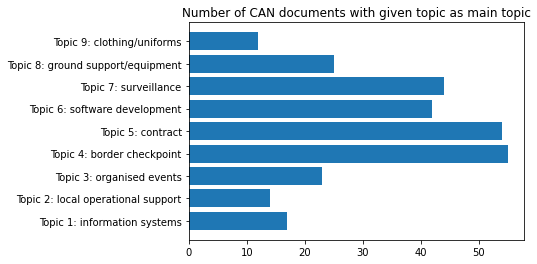

In [51]:
# plot the number of documents per dominant topic
document_dist = []
for topic_n in range(len(data_lda[0])):
    n_docs = len([i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n])
    document_dist.append(n_docs)
    
plt.barh([f"Topic {key}: {topic_names[key]}" for key in range(1,len(topic_names) + 1)], document_dist)
plt.title("Number of CAN documents with given topic as main topic")

In [12]:
def describe_doc(doc_id, plot=True):
    """
    Gives a description of a certain document, showing it's content as well
    as its topic distribution.
    """
    
    print("Description:")
    print(descriptions["Short description"].iloc[doc_id])

    sorted_topic = np.sort(data_lda[doc_id])[::-1]
    sorted_topic_index = np.argsort(data_lda[doc_id])[::-1]
    
    print("\nTopics (ranked):")
    topic_strings = []
    topic_weights = []
    for i in range(len(sorted_topic)):
        topic_n = sorted_topic_index[i] + 1
        topic_name = topic_names[topic_n]
        topic_weight = sorted_topic[i]
        
        if plot:
            topic_strings.append(f"Topic {topic_n}: {topic_names[topic_n]}")
            topic_weights.append(topic_weight)
        else:
            print(f"    Topic {topic_n}: {topic_name:<20}{topic_weight:20.9f}")

    if plot:
        plt.figure()
        plt.barh(
            topic_strings[::-1],
            topic_weights[::-1]
        )  

doc_id: 185
Description:
Provision of externally hosted nautical chart OGC compliant web map and web map tile service (WMS/WMTS) that can be integrated into Frontex applications allowing to display maritime information on their natural background. Detailed description of the deliverables are in tender documentations.

Topics (ranked):


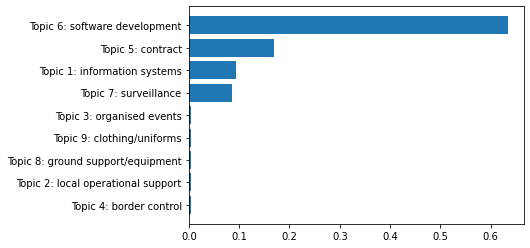

In [14]:
# Sample a random document and print topic
doc_id = np.random.randint(0, len(descriptions["Short description"]) - 1)
print(f"doc_id: {doc_id}")
describe_doc(doc_id)

In [ ]:
# For a given topic sample a random document with that
# topic as its dominant topic
topic_n = 8
print(f"Topic: {topic_n} - {topic_names[topic_n]}")

# all documents with a given topic as dominant topic
topic_docs = [i for i, val in enumerate(data_lda) if np.argsort(val)[-1] == topic_n - 1]
print(f"Number of documents for this topic: {len(topic_docs)}\n")

# a random document of the given topic
for doc_id in random.sample(topic_docs, k=1):
    print(f"doc_id: {doc_id}")
    describe_doc(doc_id, plot=True)
    print("="*80)

## Topic distribution per year

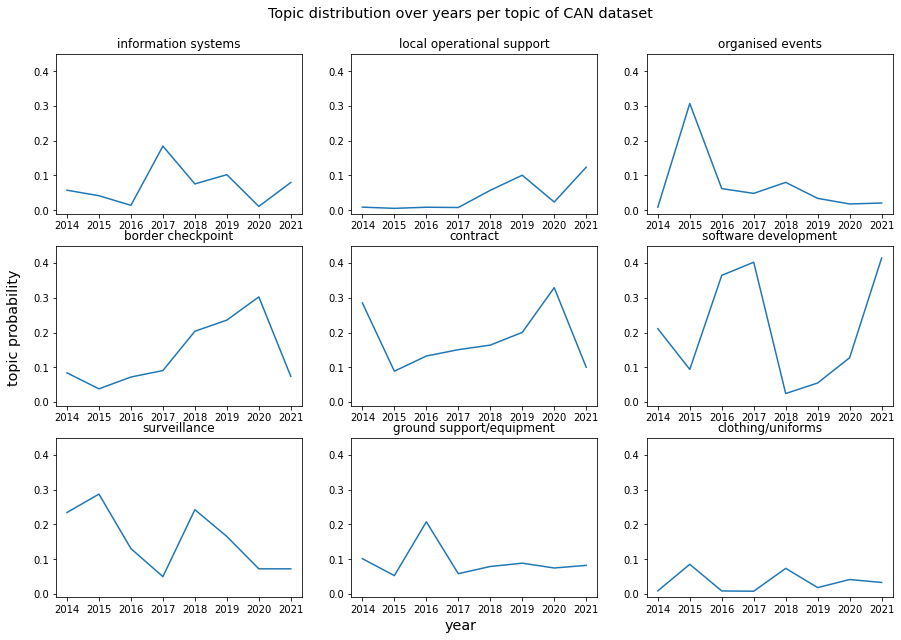

In [8]:
# create topic distribution per year
data = descriptions
topic_dist_years = []
for year in [str(y) for y in range(2014, 2022)]:
    ids = data[data["Notice dispatch date"].str.contains(year)].index
    topic_dist = np.mean(data_lda[ids], axis=0)
    topic_dist_years.append(topic_dist)
    
    
# plot the distribution of each topic over the years
fig = plt.figure(figsize = (15,10))
fig.text(0.5, 0.93, "Topic distribution over years per topic of CAN dataset", ha='center', fontsize="x-large")
fig.text(0.5, 0.08, 'year', ha='center', fontsize="x-large")
fig.text(0.08, 0.5, 'topic probability', va='center', rotation='vertical', fontsize="x-large")
fig.tight_layout(pad=1.0)
for topic_index in range(len(data_lda[0])):
    plt.subplot(3,int(np.ceil(len(data_lda[0])/3)), topic_index+1)
    plt.plot(list(range(2014, 2022)), [x[topic_index] for x in topic_dist_years])
    plt.title(topic_names[topic_index+1])
    plt.ylim(top=0.45, bottom=-0.01)